<a href="https://colab.research.google.com/github/VMBoehm/N3ASProject_Annie/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import keras

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize

In [ ]:
from keras.datasets import mnist

# input image dimensions
num_classes = 10 # 10 digits
img_rows, img_cols = 28, 28 # number of pixels
# the data, shuffled and split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train[:40000]
Y_train = Y_train[:40000]
# reshape data, depending on Keras backend
# X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
# X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
# cast floats to single precesion
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

#np.save('X_train.npy', X_train)

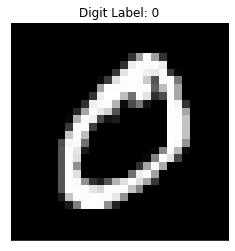

(40000, 28, 28)


In [ ]:
plt.imshow(X_train[1], cmap="gray")
plt.title("Digit Label: " + str(Y_train[1]))
plt.xticks([])
plt.yticks([])
plt.show()
print(X_train.shape)


In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
! ls drive/MyDrive/Junior_Year/N3AS

 bunny_conversion.ipynb		     images.npy
 bunny.csv			    'Optimize neural network.gdoc'
'Contrastive Learning.gdoc'	    'Time Sheet.gsheet'
 DR16_denoised_inpainted_test.npy    X_train.npy
 DR16_denoised_inpainted_train.npy   Y_train.npy


In [ ]:
INPUT_SIZE      = 1000
LATENT_SIZE     = 6

In [ ]:
#class SDSS_DR16(Dataset):
class Images_data(Dataset):
    """De-redshifted and downsampled spectra from SDSS-BOSS DR16"""

    def __init__(self, root_dir='drive/MyDrive/Junior_Year/N3AS/', transform=True, train=True):
        """
        Args:
            root_dir (string): Directory of data file
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        if train:
            self.data = np.load(open(os.path.join(root_dir,'images.npy'),'rb'),allow_pickle=True)
        else:
            self.data = np.load(open(os.path.join(root_dir,'images.npy'),'rb'),allow_pickle=True)
        self.data = self.data.astype('float')
        self.data = torch.as_tensor(self.data)
        self.mean = torch.mean(self.data)
        self.std  = torch.std(self.data)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = (self.data[idx]-self.mean)/self.std

        return sample


#initialize datasets
training_data = Images_data(train=True)
test_data     = Images_data(train=False)

ValueError: ignored

In [ ]:
# we inherit from pytorch Module class; https://pytorch.org/docs/stable/generated/torch.nn.Module.html

class Encoder(nn.Module):
    def __init__(self, seed=853):
        """
        seed: int, random seed for reproducibility
        """
        super(Encoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        # here we are initializing the linear layers. This registeres the layer parameters (W,b) as parameters of the Module
        self.fc1 = nn.Linear(INPUT_SIZE,50)
        self.fc2 = nn.Linear(50,LATENT_SIZE)

    # this defines a forward pass of the network (="applying" the network to some input data)
    def forward(self, x):
        x      = torch.nn.LeakyReLU()(self.fc1(x))
        z      = self.fc2(x)
        return z


class Decoder(nn.Module):
    def __init__(self, seed=620):
        """
        seed: int, random seed for reproducibility
        """
        super(Decoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(LATENT_SIZE,50)
        self.fc2 = nn.Linear(50,INPUT_SIZE)

    def forward(self, z):
        z = torch.nn.LeakyReLU()(self.fc1(z))
        x = self.fc2(z)
        return x

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # here we are creating instances of the Encoder and Decoder class
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

In [ ]:
# This creates an instance of the Autoencoder class
AE = Autoencoder()

In [ ]:
# the training loop takes a function that loads the data batch by batch, a model to train, a loss function to train the model on and an optimizer
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    # iterate over the dataset
    for batch, X in enumerate(dataloader):
        # Compute prediction of the model (in case of the AE the prediction is the reconstructed data)
        pred = model(X)
        # Compute the loss function (in case of the AE this is the L2 distance to the input data)
        loss = loss_fn(pred,X)

        # Backpropagation; this is where we take the gradient and update the network parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # here we keep track of the loss
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            losses.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    return losses


# the test loop is similar to the training loop, only that we don't take any gradients/don't update the network parameters, but only evaluate
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss =  0
    with torch.no_grad():
        for X in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, X).item()

    test_loss /= num_batches
    print(f" Avg loss: {test_loss:>8f} \n")

    return test_loss

In [ ]:
BATCHSIZE       = 128
BATCHSIZE_TEST  = 256
LEARNING_RATE   = 1e-3

# MeanSquaredError (L2) Loss
loss_fn         = nn.MSELoss()
# Adam Optimizer
optimizer       = torch.optim.Adam(AE.parameters(), lr=LEARNING_RATE)

# Dataloaders
train_dataloader = DataLoader(training_data, batch_size=BATCHSIZE, shuffle=True)
test_dataloader  = DataLoader(test_data, batch_size=BATCHSIZE_TEST, shuffle=True)

In [ ]:
EPOCHS = 30
SEED   = 555  

train_loss = []
test_loss  = []
for t in range(EPOCHS):
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    np.random.seed(SEED)
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_loop(train_dataloader, AE, loss_fn, optimizer))
    test_loss.append(test_loop(test_dataloader, AE, loss_fn))
print("Done!")

Epoch 1
-------------------------------
loss: 0.662359  [    0/100000]
loss: 0.021183  [12800/100000]
loss: 0.033737  [25600/100000]
loss: 0.018337  [38400/100000]
loss: 0.007415  [51200/100000]
loss: 0.013185  [64000/100000]
loss: 0.009776  [76800/100000]
loss: 0.006133  [89600/100000]
 Avg loss: 0.008382 

Epoch 2
-------------------------------
loss: 0.004359  [    0/100000]
loss: 0.027580  [12800/100000]
loss: 0.005040  [25600/100000]
loss: 0.004220  [38400/100000]
loss: 0.010213  [51200/100000]
loss: 0.006733  [64000/100000]
loss: 0.004300  [76800/100000]
loss: 0.003772  [89600/100000]
 Avg loss: 0.006230 

Epoch 3
-------------------------------
loss: 0.003231  [    0/100000]
loss: 0.027524  [12800/100000]
loss: 0.004296  [25600/100000]
loss: 0.003610  [38400/100000]
loss: 0.004937  [51200/100000]
loss: 0.005583  [64000/100000]
loss: 0.003153  [76800/100000]
loss: 0.003376  [89600/100000]
 Avg loss: 0.005067 

Epoch 4
-------------------------------
loss: 0.002500  [    0/100000]